In [1]:
import numpy as np
import h5py
import pandas as pd
from tqdm import tqdm

from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist
from sklearn.model_selection import StratifiedKFold

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('white')
sns.set_context('poster')

In [2]:
def bipolarize(Y):
    X = np.copy(Y)
    X[X > 0] = 1.0
    X[X < 0] = -1.0
    X[X == 0] = np.random.choice([-1.0, 1.0], size=len(X[X == 0]))
    return X

def centroids(X,label=None):
    if label is not None:
        cLabel = np.unique(label)
        c = np.zeros((len(cLabel), X.shape[1]))
        for i,l in enumerate(cLabel):
            c[i,:] = bipolarize(np.sum(X[label==l],axis=0))
    else:
        c = bipolarize(np.sum(X,axis=0)).reshape(1,-1)
        cLabel = [0]
    return cLabel, c.astype('int')

def classify(v,am,metric):
    d = cdist(v,am,metric)
    label = np.argmin(d,axis=1)
    return label

In [3]:
dataFile = 'data.mat'
file = h5py.File(dataFile,'r')
experimentData = file['experimentData']
keys = list(experimentData.keys())
numTrials, numPositions, numGestures = experimentData[keys[0]].shape
D = file[experimentData[keys[3]][0,0,0]].shape[1]
numEx = 80

In [4]:
xRange = 10000
yRange = 5000
zRange = 6000
CIMRanges = (xRange, yRange, zRange)
xQuant = 59
yQuant = 55
zQuant = 14
NQuants = (xQuant, yQuant, zQuant)

# xRange = 5000
# yRange = 5000
# zRange = 5000
# CIMRanges = (xRange, yRange, zRange)
# xQuant = 64
# yQuant = 64
# zQuant = 64
# NQuants = (xQuant, yQuant, zQuant)

ims = []
for i in range(3):
    im = np.zeros((NQuants[i],D))
    seed = np.random.choice([-1.0, 1.0], size=D)
    flipBits = np.random.permutation(D)
    numFlip = np.round(np.linspace(0,CIMRanges[i],NQuants[i])).astype('int')
    for x in range(NQuants[i]):
        im[x,:] = seed
        im[x,flipBits[:numFlip[x]]] *= -1
    ims.append(im)

In [5]:
totalEx = numEx*numGestures*numPositions*numTrials

hv = np.zeros((totalEx,D),dtype=np.int8)
gestLabel = np.zeros(totalEx,dtype='int')
posLabel = np.zeros(totalEx,dtype='int')

idx = np.arange(numEx).astype('int')
for g in tqdm(range(numGestures)):
    for p in range(numPositions):
        for t in range(numTrials):
            expLabel = file[experimentData['expGestLabel'][t,p,g]][0,:]
            r = file[experimentData['emgHV'][t,p,g]][expLabel>0,:]
            accFeat = file[experimentData['accFeat'][t,p,g]][:,expLabel>0].T
            
            accIdx = np.zeros(accFeat.shape,dtype='int')
            for ax in range(3):
                accIdx[:,ax] = np.floor((accFeat[:,ax] + 1)/2*(NQuants[ax])).astype('int')
                accIdx[accIdx[:,ax] < 0,ax] = 0
                accIdx[accIdx[:,ax] > NQuants[ax]-1,ax] = NQuants[ax]-1
            
            xHV = ims[0][accIdx[:,0]]
            yHV = ims[1][accIdx[:,1]]
            zHV = ims[2][accIdx[:,2]]
            
            hv[idx,:] = xHV*yHV*zHV

            gestLabel[idx] = g
            posLabel[idx] = p
            idx += numEx

100%|██████████| 13/13 [00:05<00:00,  2.21it/s]


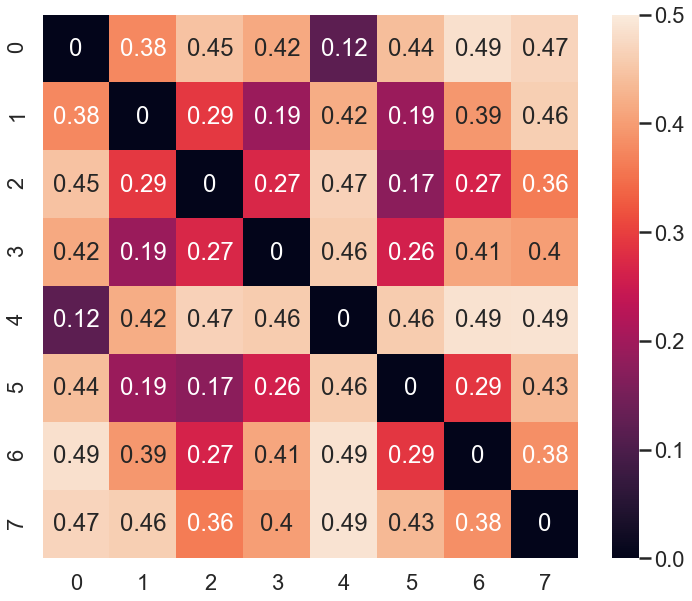

In [8]:
cm = centroids(hv,label=posLabel)[1]
cm_d = cdist(cm,cm,'hamming')

f,ax = plt.subplots(figsize=(12,10))
sns.heatmap(cm_d,vmin=0,vmax=0.5,ax=ax,annot=True)
# plt.show()
plt.savefig('continuous_cm.svg')